24-mel-band-LMPSC

In [11]:
import librosa
import scipy
import scipy.io
import numpy as np
import torch
import torchaudio
import matplotlib.pyplot as plt
import librosa.display
import soundfile

## Data Load

In [12]:
noisy, sr = librosa.load('input.wav',sr=16000)
estim, sr = librosa.load('estimated.wav',sr=16000)
noise_mask = scipy.io.loadmat('noise_mask.mat')
noise_mask = noise_mask['noise_mask']

## Setting

In [13]:
fft_size = 1024
mel_band = 24

In [14]:
window = torch.hann_window(window_length=fft_size,periodic=True, dtype=None, 
                           layout=torch.strided, device=None, requires_grad=False)

## Normalization

In [15]:
max_val = np.max(np.abs(noisy))
noisy = noisy / max_val

max_val = np.max(np.abs(estim))
estim = estim / max_val

In [16]:
unsync_noisy = noisy.view()

## Syncronization

In [17]:
def cross_correlation_using_fft(x, y):
    f1 = np.fft.fft(x)
    f2 = np.fft.fft(np.flipud(y))
    cc = np.real(np.fft.ifft(f1 * f2))
    return np.fft.fftshift(cc)

# shift < 0 means that y starts 'shift' time steps before x 
# shift > 0 means that y starts 'shift' time steps after x
def compute_shift(x, y):
    assert len(x) == len(y)
    c = cross_correlation_using_fft(x, y)
    assert len(c) == len(x)
    zero_index = int(len(x) / 2) - 1
    shift = zero_index - np.argmax(c)
    return shift

In [18]:
diff = compute_shift(estim,noisy)
estim = estim[-diff:]
noisy = noisy[:len(estim)]

## Spectrum

In [19]:
spec_noisy = librosa.stft(noisy,window='hann', n_fft=fft_size, hop_length=None , win_length=None ,center=False)
spec_estim = librosa.stft(estim,window='hann', n_fft=fft_size, hop_length=None , win_length=None ,center=False)
spec_unsync_noisy = librosa.stft(unsync_noisy,window='hann', n_fft=fft_size, hop_length=None , win_length=None ,center=False)

In [20]:
display(spec_noisy.shape)
display(spec_estim.shape)
display(spec_unsync_noisy.shape)

(513, 383)

(513, 383)

(513, 386)

In [21]:
display(type(spec_noisy))

numpy.ndarray

* Note   
if ```center``` is ```True(default) ``` torch stft will use padding for the input and use residual samples in the end.


## Masking

In [22]:
spec_noise = spec_unsync_noisy*noise_mask

## Sync Masked

In [23]:
noise = librosa.istft(spec_noise,window='hann', hop_length=None , win_length=None ,center=False)
noise = noise[:len(estim)]
spec_noise = librosa.stft(noise,window='hann', n_fft=fft_size, hop_length=None , win_length=None ,center=False)

## Check Point

In [24]:
display(spec_noisy.shape)
display(spec_estim.shape)
display(spec_noise.shape)

(513, 383)

(513, 383)

(513, 383)

## LMPSC

[Melspectrogram](https://librosa.org/doc/main/generated/librosa.feature.melspectrogram.html#librosa.feature.melspectrogram)  
[Mel filter-bank](https://librosa.org/doc/main/generated/librosa.filters.mel.html#librosa.filters.mel)  


In [27]:
lmpsc_noisy = librosa.feature.melspectrogram( S=spec_noisy, n_fft=fft_size, hop_length=int(fft_size/4),
                               win_length=None, window='hann', center=False, pad_mode='reflect', power=2.0, n_mels=mel_band)
lmpsc_estim = librosa.feature.melspectrogram( S=spec_estim, n_fft=fft_size, hop_length=int(fft_size/4), 
                               win_length=None, window='hann', center=False, pad_mode='reflect', power=2.0, n_mels=mel_band)
lmpsc_noise = librosa.feature.melspectrogram( S=spec_noise, n_fft=fft_size, hop_length=int(fft_size/4), 
                               win_length=None, window='hann', center=False, pad_mode='reflect', power=2.0, n_mels=mel_band)

In [28]:
display(type(lmpsc_noisy))
display(lmpsc_noisy.shape)

numpy.ndarray

(24, 383)

[Text(0.5, 1.0, 'spec')]

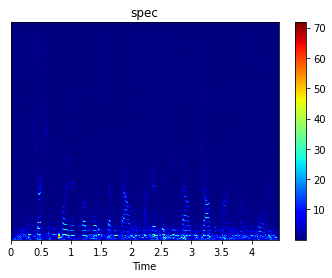

In [29]:
fig, ax = plt.subplots()
img = librosa.display.specshow(spec_noisy,hop_length =int(fft_size/4), x_axis='time', ax=ax,cmap='jet')
fig.colorbar(img, ax=ax)
ax.set(title='spec')

[Text(0.5, 1.0, 'LMPSC')]

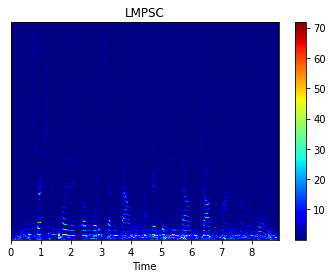

In [30]:
fig, ax = plt.subplots()
img = librosa.display.specshow(spec_noisy, x_axis='time', ax=ax,cmap='jet')
fig.colorbar(img, ax=ax)
ax.set(title='LMPSC')

## MFCC

In [17]:
mfcc_noisy = librosa.feature.mfcc(y=noisy,sr=16000,n_mfcc=40,n_fft=fft_size, hop_length=int(fft_size/4),center=False)
mfcc_estim = librosa.feature.mfcc(y=estim,sr=16000,n_mfcc=13,n_fft=fft_size, hop_length=int(fft_size/4),center=False)
mfcc_noise = librosa.feature.mfcc(y=noise,sr=16000,n_mfcc=13,n_fft=fft_size, hop_length=int(fft_size/4),center=False)

In [18]:
display(mfcc_noisy.shape)

(40, 383)

In [19]:
lmpsc_noisy = np.log(mfcc_noisy)

<ipython-input-19-8e2521571a27>:1: RuntimeWarning: invalid value encountered in log
  lmpsc_noisy = np.log(mfcc_noisy)


## [test] Visualization

[Text(0.5, 1.0, 'MFCC')]

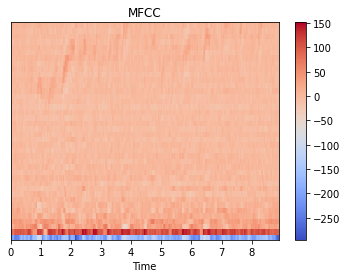

In [20]:
fig, ax = plt.subplots()
img = librosa.display.specshow(mfcc_noisy, x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='MFCC')

[Text(0.5, 1.0, 'MFCC')]

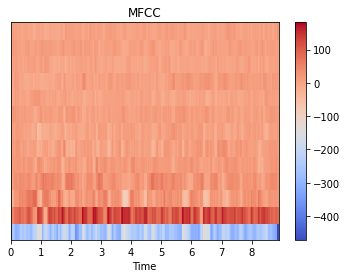

In [21]:
fig, ax = plt.subplots()
img = librosa.display.specshow(mfcc_estim, x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='MFCC')

## [test]ISTFT

In [22]:
noise = librosa.istft(spec_noise,window='hann', hop_length=None , win_length=None ,center=False)
noisy = librosa.istft(spec_noisy,window='hann', hop_length=None , win_length=None ,center=False)
estim = librosa.istft(spec_estim,window='hann', hop_length=None , win_length=None ,center=False)

## [test]Save

In [23]:
soundfile.write('output_noisy.wav',noisy,16000);
soundfile.write('output_estim.wav',estim,16000);
soundfile.write('output_noise.wav',noise,16000);

In [24]:
noise = librosa.istft(spec_noise,window='hann', hop_length=None , win_length=None ,center=False)